In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

import scipy.stats as st

<h1> Data Source </h1>

https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

<h1> Preprossesing </h1>

In [2]:
def clean(d): #Impute, Remove Outliers, Format Column Names

    sr = d.isnull().mean()
    to_impute = sr[sr>0].index.to_list()
    for c in to_impute:
        d = impute(d,c) 

    for c in d.columns:
        
        if(np.issubdtype(d[c].dtype,np.number)):
            d = rmvOutliers(d,c)

        else:
            d[c] = d[c].astype('category').cat.codes

        d = d.rename(columns={c:c.strip()})
        d = d.reset_index(drop = True)

    return d


def impute(d,c): #Use Median if numeric and Mode if not
    
    if(np.issubdtype(d[c].dtype,np.number)):
        d.loc[d[c].isnull(),c] = d[c].median()
    else:
        d.loc[d[c].isnull(),c] = d[c].mode()
    
    return d

def rmvOutliers(d,c): #Use Inner Quantile Rule

    sr = d.describe().loc[:,c]

    lq = sr.loc['25%'] #Lower Quartile
    uq = sr.loc['75%'] #Upper Quartile
    iq = uq - lq #Inner Quartile

    lb = lq - (1.5*iq)
    ub = uq + (1.5*iq)

    d = d[ (d[c] > lb) & (d[c] < ub)]
    
    return d

<h1> Plotting </h1>

In [56]:
def corrPlot(d): #Plot Correlation Bar Plot

    sns.set(rc={'figure.figsize':(15,8)})
    corr = d.corr().loc['Life expectancy'].drop(index='Life expectancy')

    sns.set(rc={'figure.figsize':(20,5)})
    ax = sns.barplot(x=corr.index,y=corr, color='#7297A0')

    plt.xticks(fontsize=12, weight='bold', rotation=40, ha='right')
    plt.yticks(fontsize=12, weight='bold')

    ax.set_ylabel(ylabel="Life expectancy",fontsize=16, weight='bold')
    ax.set_facecolor('white')
    ax.set_title("Correlation of Features with Target", size=25)

    return ax

def histPlot(d): #Plot Distribution of Every Variable

    sns.set(rc={'figure.figsize':(20,8)})
    fig, axs = plt.subplots(nrows= 4, ncols= 5)
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for ax in axs.flatten():
        ax.set_facecolor('white')
    
    cnt = 0
    for c in list(d.select_dtypes(include=numerics)):

        d[c].hist(bins='auto',ax=axs[cnt%4,cnt%5],density=True, color='#82AC7C')
        axs[cnt%4,cnt%5].set_title(c,weight = 'bold')
        plt.subplots_adjust(hspace=0.75,wspace=.25)

        cnt += 1

    fig.suptitle("Frequency Plots", weight='bold', size=25)

    return fig

def targetPlot(d):

    sns.set(rc={'figure.figsize':(10,6)})
    fig = sns.kdeplot(d['Life expectancy'])
    ax = plt.gca()

    ax.set_facecolor('white')
    ax.set_title("Life Expectancy Distribution", fontsize=16, weight='bold', pad=16)

    plt.xticks(fontsize=12, rotation=40, ha='right')
    plt.yticks(fontsize=12)

    ax.set_xlabel(xlabel="Life Expectancy",fontsize=16, weight='bold' ,labelpad=16)
    ax.set_ylabel(ylabel="Density",fontsize=16, weight='bold' ,labelpad=16)

    return fig

<h1> Model Evaluation </h1>

In [ ]:
from datetime import datetime as dtm
#GPA
c = pd.read_csv('/Users/gpoulsen@apamail.org/Desktop/One Pager/Students/Students_W2.csv')
c = c[c['Gr'] > 6]

g = pd.read_csv('/Users/gpoulsen@apamail.org/Desktop/One Pager/GPA/GPA.csv')
g = g[g.columns.drop(list(g.filter(regex='Unnamed')))]

s = pd.read_csv('/Users/gpoulsen@apamail.org/Desktop/One Pager/AS/SY23.csv').drop(columns=['1','2','3','4']).query("Sch == 'W3'")
mp = s.groupby('OID')['Dt'].nunique()

cl = pd.read_csv('/Users/gpoulsen@apamail.org/Desktop/One Pager/AS/W3_Clb.csv').dropna(how='all').drop(columns=['CN','Gr','Min']).drop_duplicates()

cl = cl[cl['Dt'].notnull()]
cl = cl[~cl['Dt'].str.contains('-May')]
cl['Dt'] = pd.to_datetime(cl['Dt'])
cl = cl[ (cl['Dt'] >= dtm(2022,8,1)) & (cl['Dt'] <= dtm(2023,6,8))] 
cl['Dt'] = cl['Dt'].dt.date
cl = cl.merge(s.drop(columns=['Dt']).drop_duplicates(),'left','OID')
cl['Gr'] = cl['Gr'].fillna(-1)

s = pd.concat([s,cl],ignore_index=True).sort_values(by='OID')
s = s[s['OID'].notnull()]

mp = s.groupby('OID')['Dt'].nunique()
s['Reg'] = s['OID'].apply(lambda x: 1 if mp[x] >=30 else 0)
s = s.drop(columns=['Dt','Gr']).drop_duplicates()

c = c.merge(s,'left','OID')
c['AS'] = 0
c.loc[c['Reg'].notnull(),'AS'] = 1
c['Reg'] = c['Reg'].fillna(0)

fr = c.merge(g,'left','OID').dropna(subset='GPA').drop(columns=['ED','WD','Sch'])

In [27]:
def evaluateModel(rg,predictors,prms):

    Y = d['Life expectancy'] #Target Feature
    X = d[[c for c in d.columns if c != 'Life expectancy']] #Remove Target
    X = d[predictors]

    grid_search = GridSearchCV(estimator=rg, param_grid=prms, cv=LeaveOneOut(), n_jobs=-1, scoring = 'neg_root_mean_squared_error').fit(X,Y)
    
    print("The Best Score Evaluates to : " + str(abs(grid_search.best_score_)) + " with parameters chosen as " + str(grid_search.best_params_))

<h1> Load </h1>

In [28]:
d = pd.read_csv("/Users/gpoulsen@apamail.org/Desktop/Grant Training/Life Expectancy/Life Expectancy Data.csv")
d = clean(d)

<h1> Plot Figures </h1>

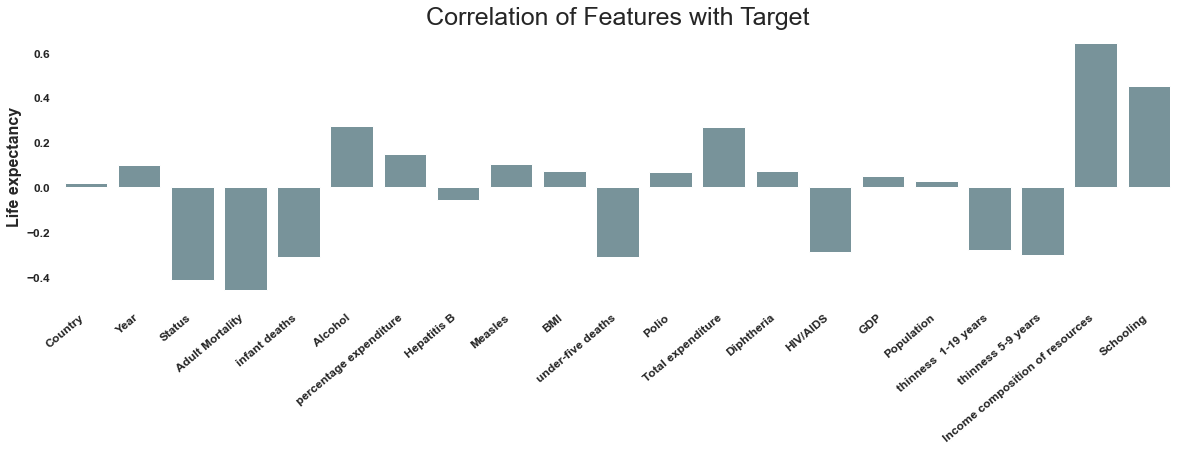

In [29]:
crr = corrPlot(d)
predictors = list(abs(d.corr().loc['Life expectancy'].drop(index='Life expectancy')).sort_values(ascending=False).head(5).index)

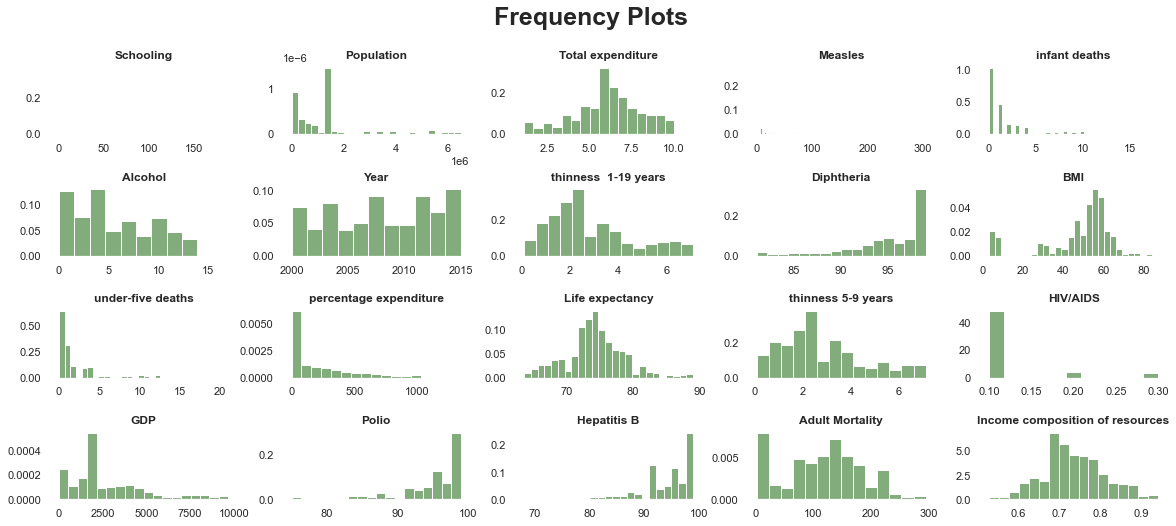

In [30]:
hst = histPlot(d)

0.28919893090387677
4.28770603032467


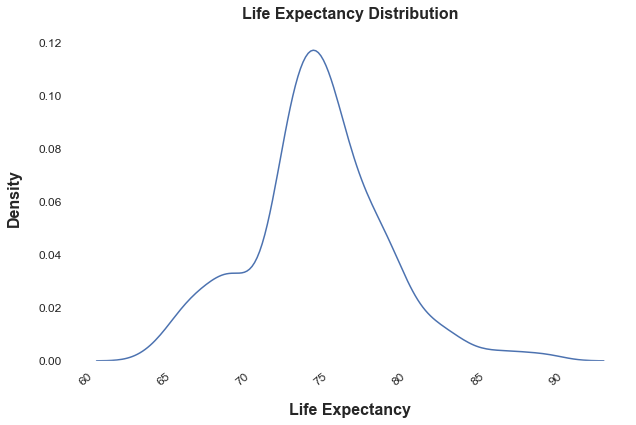

In [68]:
targetPlot(d)
print(1.24 / d.std(numeric_only=True).loc['Life expectancy'])
print(d.std(numeric_only=True).loc['Life expectancy'])

<h1> Make Optimal Deicision Tree </h1>

In [29]:
rg = DecisionTreeRegressor(random_state=0) #Model
prms = {'random_state':[0],'min_samples_leaf':range(1,100,10) ,'min_samples_split':range(2,100,10)} #Hyper Params

evaluateModel(rg,predictors,prms)

The Best Score Evaluates to : 1.4603531300160517 with parameters chosen as {'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}


<h1> Make Optimal SVR </h1>

In [30]:
rg = SVR() #Model
prms = {'degree':[1,5],'epsilon':np.linspace(start=0,stop=1,num=10),'C':np.linspace(start=.25,stop=1,num=10)} #Hyper Params

evaluateModel(rg,predictors,prms)

The Best Score Evaluates to : 2.1667492914122097 with parameters chosen as {'C': 1.0, 'degree': 1, 'epsilon': 0.2222222222222222}


<h1> Make Optimal Linear Regressor </h1>

In [31]:
rg = LinearRegression(fit_intercept=True) #Model
prms = {'fit_intercept':[True,False]} #Hyper Params

evaluateModel(rg,predictors,prms) 

The Best Score Evaluates to : 2.2274392475206493 with parameters chosen as {'fit_intercept': True}


<h1> Decision tree regressor makes for a good start. Let's try to further dig into those hyperparameters </h1>

In [59]:
def evaluateModel(rg,predictors,prms):

    Y = d['Life expectancy'] #Target Feature
    X = d[[c for c in d.columns if c != 'Life expectancy']] #Remove Target
    X = d[predictors]

    grid_search = GridSearchCV(estimator=rg, param_grid=prms, cv=LeaveOneOut(), n_jobs=-1, scoring = 'neg_root_mean_squared_error').fit(X,Y)
    
    return grid_search.best_score_

In [60]:
rg = DecisionTreeRegressor(random_state=0) #Model
prms = {'random_state':[0],'min_samples_leaf':range(1,100,10) ,'min_samples_split':range(2,100,10)} #Hyper Params

loss = []
for i,cr in enumerate(d.corr().loc['Life expectancy'].drop(index='Life expectancy')):

    predictors = list(abs(d.corr().loc['Life expectancy'].drop(index='Life expectancy')).sort_values(ascending=False).head(i+1).index)
    loss.append(evaluateModel(rg,predictors,prms))

loss = [abs(e) for e in loss]

In [62]:
import pickle

with open('/Users/gpoulsen@apamail.org/Desktop/Grant Training/Urban-Growth/Project/Loss.txt', 'wb') as fp:
    pickle.dump(loss,fp)

with open('/Users/gpoulsen@apamail.org/Desktop/Grant Training/Urban-Growth/Project/Loss.txt', 'rb') as fp:
    loss = pickle.load(fp)

In [65]:
loss[8]

1.2470304975922957

9


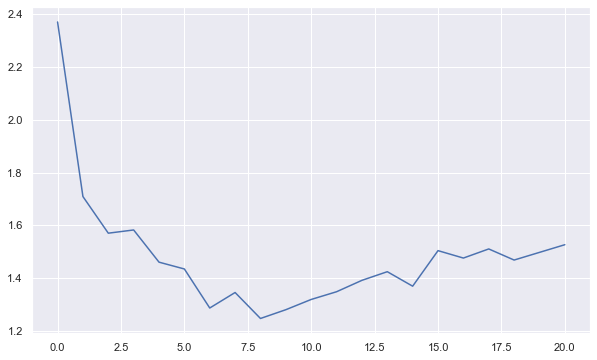

In [63]:
plt.plot(loss)
print(loss.index(min(loss)) + 1)